In [1]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import os
from azure.storage.blob import ContainerClient
import io
import time
from PIL import Image
import datetime
import argparse
from bivariate import gaussian_blur, skew_blur

In [2]:
def pixel_coord_np(height,width):
    """
    Pixel in homogenous coordinate
    Returns:
        Pixel coordinate:       [3, width * height]
    """
    x = np.linspace(0, width - 1, width)
    y = np.linspace(0, height - 1, height)
    return np.vstack((x.flatten(), y.flatten(), np.ones_like(x.flatten())))


def intrinsic_from_fov1(height, width, fov=90):
    """
    Basic Pinhole Camera Model
    intrinsic params from fov and sensor width and height in pixels
    Returns:
        K:      [4, 4]
    """
    px, py = (width / 2, height / 2)
    hfov = fov / 360. * 2. * np.pi
    fx = width / (2. * np.tan(hfov / 2.))

    vfov = 2. * np.arctan(np.tan(hfov / 2) * height / width)
    fy = height / (2. * np.tan(vfov / 2.))
    
    bx = 0.25
    return np.array([[fx, 0, px, 0.],
                    [0, fy, py, 0.],
                    [0, 0, 1., 0.],
                    [0, 0., 0., 1.]
                    ])
    
def intrinsic_from_fov2(height, width, fov=90):
    """
    Basic Pinhole Camera Model
    intrinsic params from fov and sensor width and height in pixels
    Returns:
        K:      [4, 4]
    """
    px, py = (width / 2, height / 2)
    hfov = fov / 360. * 2. * np.pi
    fx = width / (2. * np.tan(hfov / 2.))

    vfov = 2. * np.arctan(np.tan(hfov / 2) * height / width)
    fy = height / (2. * np.tan(vfov / 2.))
    
    bx = 0.25
    return np.array([[fx, 0, px, -fx*bx],
                    [0, fy, py, 0.],
                    [0, 0, 1., 0.],
                    [0, 0., 0., 1.]
                    ])

def quaternion_rotation_matrix(Q):
    """
    Covert a quaternion into a full projection matrix.
 
    Input
    :param Q: A 7 element array representing translation and the quaternion (q0,q1,q2,q3) 
 
    Output
    :return: A 3x4 element matrix representing the full projection matrix. 
             This projection matrix converts a point in the local reference 
             frame to a point in the global reference frame.
    """
    # Extract the values from Q
    t0 = Q[0]
    t1 = Q[1]
    t2 = Q[2]
    q0 = Q[3]
    q1 = Q[4]
    q2 = Q[5]
    q3 = Q[6]
     
    # First row of the rotation matrix
    r00 = 2 * (q0 * q0 + q1 * q1) - 1
    r01 = 2 * (q1 * q2 - q0 * q3)
    r02 = 2 * (q1 * q3 + q0 * q2)
     
    # Second row of the rotation matrix
    r10 = 2 * (q1 * q2 + q0 * q3)
    r11 = 2 * (q0 * q0 + q2 * q2) - 1
    r12 = 2 * (q2 * q3 - q0 * q1)
     
    # Third row of the rotation matrix
    r20 = 2 * (q1 * q3 - q0 * q2)
    r21 = 2 * (q2 * q3 + q0 * q1)
    r22 = 2 * (q0 * q0 + q3 * q3) - 1
     
    # 3x4 projection matrix
    pro_matrix = np.array([[r00, r01, r02, t0],
                           [r10, r11, r12, t1],
                           [r20, r21, r22, t2]])
                            
    return pro_matrix

In [3]:
class Dataset_Handler():
    def __init__(self, sequence, low_memory=True):
        
        

        # This will tell odometry functin how to access data from this object
        self.low_memory = low_memory
        
        # Set file paths and get ground truth poses
        self.seq_dir = "../../data_KITTI\data_odometry_gray\dataset\sequences\{}/".format(sequence)
        self.poses_dir = "../../data_KITTI\data_odometry_poses\dataset\poses\{}.txt".format(sequence)
        self.depth_dir = "../../data\{}/".format(sequence)

        poses = pd.read_csv(self.poses_dir, delimiter=' ', header=None)
        
        # Get names of files to iterate through
        self.left_image_files = os.listdir(self.seq_dir + 'image_0')
        self.right_image_files = os.listdir(self.seq_dir + 'image_1')
        self.left_depth_files = os.listdir(self.depth_dir + 'depth_left')
        self.right_depth_files = os.listdir(self.depth_dir + 'depth_right')
        
        self.num_frames = 20 #len(self.left_image_files)
        # print(self.num_frames)
        self.first_image_left = cv2.imread(self.seq_dir + 'image_left/' 
                                               + self.left_image_files[0],0)
        height = 480
        width = 640
        calib = pd.read_csv(self.seq_dir + 'calib.txt', delimiter=' ', header=None, index_col=0)
        self.P0 = np.array(calib.loc['P0:']).reshape((3,4))
        self.P1 = np.array(calib.loc['P1:']).reshape((3,4))
        self.P2 = np.array(calib.loc['P2:']).reshape((3,4))
        self.P3 = np.array(calib.loc['P3:']).reshape((3,4))
        
        
        # Get calibration details for scene
        # calib = pd.read_csv(self.seq_dir + 'calib.txt', delimiter=' ', header=None, index_col=0)
        # self.P0 = np.array(calib.loc['P0:']).reshape((3,4))
        # self.P1 = np.array(calib.loc['P1:']).reshape((3,4))
        # self.P2 = np.array(calib.loc['P2:']).reshape((3,4)) #RGB cams
        # self.P3 = np.array(calib.loc['P3:']).reshape((3,4)) #RGB cams

        
        # Get times and ground truth poses
        self.times = np.array(pd.read_csv(self.seq_dir + 'times.txt', 
                                          delimiter=' ', 
                                          header=None))
        self.gt = np.zeros((self.num_frames, 3, 4)) #instead of len(poses)
        for i in range(self.num_frames):
            self.gt[i] = np.array(poses.iloc[i]).reshape((3, 4))
        
        if self.low_memory:
            # Will use generators to provide data sequentially to save RAM
            # Use class method to set up generators
            self.reset_frames()
            # Store original frame to memory for testing functions
            self.first_image_left = cv2.imread(self.seq_dir + 'image_0/' 
                                               + self.left_image_files[0],0)
            self.first_image_right = cv2.imread(self.seq_dir + 'image_1/' 
                                               + self.right_image_files[0],0)
            self.second_image_left = cv2.imread(self.seq_dir + 'image_0/' 
                                               + self.left_image_files[1],0)
            self.first_depth_left = np.load(self.depth_dir + 'depth_left/'
                                                + self.left_depth_files[0])
            self.first_depth_right = np.load(self.depth_dir + 'depth_right/'
                                                + self.right_depth_files[0])
            self.second_depth_left = np.load(self.depth_dir + 'depth_left/'
                                                + self.left_depth_files[1])
                                                
            
            self.imheight = self.first_image_left.shape[0]
            self.imwidth = self.first_image_left.shape[1]
            
        else:
            # If RAM is not a concern (>32GB), pass low_memory=False
            
            self.images_left = []
            self.images_right = []
            self.depths_left = []
            self.depths_right =[]
            self.pointclouds = []
            for i, name_left in enumerate(self.left_image_files):
                name_right = self.right_image_files[i]
                d_left = self.left_depth_files
                d_right = self.right_depth_files
                self.images_left.append(cv2.imread(self.seq_dir + 'image_0/' + name_left))
                self.images_right.append(cv2.imread(self.seq_dir + 'image_1/' + name_right))
                self.depths_left.append(np.load(self.depth_dir + 'depth_left/' + d_left))
                self.depths_right.append(np.load(self.depth_dir + 'depth_right/' + d_right))
                
                
            self.imheight = self.images_left[0].shape[0]
            self.imwidth = self.images_left[0].shape[1]
            # Keep consistent instance variable names as when using low_memory
            self.first_image_left = self.images_left[0]
            self.first_image_right = self.images_right[0]
            self.second_image_left = self.images_left[1]
            
    def reset_frames(self):
        # Resets all generators to the first frame of the sequence
        self.images_left = (cv2.imread(self.seq_dir + 'image_0/' + name_left,0)
                            for name_left in self.left_image_files)
        self.images_right = (cv2.imread(self.seq_dir + 'image_1/' + name_right,0)
                            for name_right in self.right_image_files)
        self.depths_left = (np.load(self.depth_dir+'depth_left/' + d_left)
                            for d_left in self.left_depth_files)
        self.depths_right = (np.load(self.depth_dir+'depth_right/' + d_right)
                            for d_right in self.right_depth_files)                    
        
        pass
handler = Dataset_Handler("10")


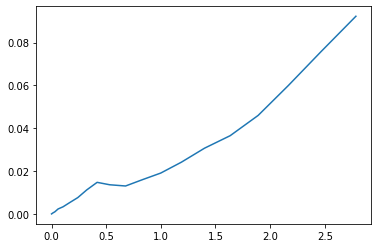

(array([1.000000e+00, 1.197625e-11, 1.704638e-10, 1.665335e-16]),
 array([ 1.197625e-11,  1.000000e+00,  3.562503e-10, -1.110223e-16]),
 array([1.704638e-10, 3.562503e-10, 1.000000e+00, 2.220446e-16]))

In [4]:

plt.plot(handler.gt[:, :, 3][:, 0], handler.gt[:, :, 3][:, 1])
plt.show()


handler.gt[0,0], handler.gt[0,1], handler.gt[0,2]

In [5]:
def compute_left_disparity_map(left_image, right_image, matcher = 'bm', rgb = True, verbose = True):
    '''
    Takes a left and right pair of images to computes the disparity map for the left
    image. 
    
    Arguments:
    img_left -- image from left camera
    img_right -- image from right camera
    
    Optional Arguments:
    matcher -- (str) can be 'bm' for StereoBM or 'sgbm' for StereoSGBM matching.
    rgb -- (bool) set to True if passing RGB images as input. 
    verbose -- (bool) set to True to report matching type and time to compute
    
    Returns:
    disp_left -- disparity map for the left camera image
    
    '''
    sad_window = 6
    num_disparities = sad_window * 16
    block_size = 11
    matcher_name = matcher

    if matcher_name == 'bm':
        matcher = cv2.StereoBM_create(numDisparities=num_disparities,
                                        blockSize=block_size)
                                        
    elif matcher_name == 'sgbm':
        matcher = cv2.StereoSGBM_create(numDisparities=num_disparities,
                                        blockSize=block_size,
                                        P1 = 8*3*sad_window**2,
                                        P2 = 32*3*sad_window**2,
                                        mode = cv2.STEREO_SGBM_MODE_SGBM_3WAY)
    if rgb:
        left_image = cv2.cvtColor(left_image, cv2.COLOR_BGR2GRAY)
        right_image = cv2.cvtColor(right_image, cv2.COLOR_BGR2GRAY)
    
    start = datetime.datetime.now()
    disp_left = matcher.compute(left_image, right_image).astype(np.float32)/16
    end = datetime.datetime.now()

    if verbose:
        print(f'Time to compute disparity map using Stereo{matcher_name.upper()}:', end-start)
    
    return disp_left


Time to compute disparity map using StereoBM: 0:00:00.008720


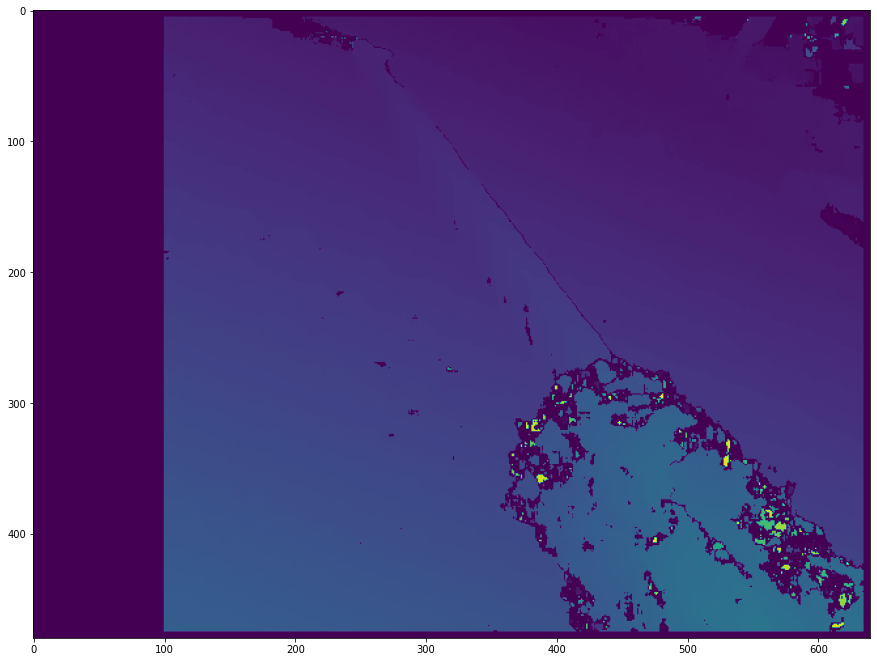

In [6]:
file_path_color_left = "data/00\image_left/"
file_path_color_right = "data/00\image_right/"

left_images = os.listdir(file_path_color_left)
right_images = os.listdir(file_path_color_right)


first_left = cv2.imread(file_path_color_left + left_images[167])
first_right = cv2.imread(file_path_color_right + right_images[167])

disp = compute_left_disparity_map(left_image=first_left, right_image=first_right,
                                    matcher = 'bm', verbose = True)

plt.figure(figsize=(15,15))
plt.imshow(disp);

In [7]:
def decompose_projection_matrix(p):
    '''
    Shortcut to use cv2.decomposeProjectionMatrix(), which only returns k, r, t, and divides
    t by the scale, then returns it as a vector with shape (3,) (non-homogeneous)
    
    Arguments:
    p -- projection matrix to be decomposed
    
    Returns:
    k, r, t -- intrinsic matrix, rotation matrix, and 3D translation vector
    
    '''
    k, r, t, _, _, _, _ = cv2.decomposeProjectionMatrix(p)
    t = (t / t[3])[:3]
    
    return k, r, t
def calc_depth_map(disp_left, k_left, t_left, t_right, rectified=True):
    '''
    Assuming we don't have access to the depth map...
    
    Calculate depth map using a disparity map, intrinsic camera matrix, and translation vectors
    from camera extrinsic matrices (to calculate baseline). Note that default behavior is for
    rectified projection matrix for right camera. If using a regular projection matrix, pass
    rectified=False to avoid issues.

    
    
    Arguments:
    disp_left -- disparity map of left camera
    k_left -- intrinsic matrix for left camera
    t_left -- translation vector for left camera
    t_right -- translation vector for right camera
    
    Optional Arguments:
    rectified -- (bool) set to False if t_right is not from rectified projection matrix
    
    Returns:
    depth_map -- calculated depth map for left camera
    
    '''
    # Get focal length of x axis for left camera
    f = k_left[0][0]
    
    # Calculate baseline of stereo pair
    if rectified:
        b = t_right[0] - t_left[0] 
    else:
        b = t_left[0] - t_right[0]
        
    # Avoid instability and division by zero
    disp_left[disp_left == 0.0] = 0.1
    disp_left[disp_left == -1.0] = 0.1
    
    # Make empty depth map then fill with depth
    depth_map = np.ones(disp_left.shape)
    depth_map = f * b / disp_left
    
    return depth_map

In [8]:
def stereo_2_depth(img_left, img_right, P0, P1, matcher='bm', rgb=False, verbose=False, 
                   rectified=True):
    '''
    Takes stereo pair of images and returns a depth map for the left camera. If your projection
    matrices are not rectified, set rectified=False.
    
    Arguments:
    img_left -- image of left camera
    img_right -- image of right camera
    P0 -- Projection matrix for the left camera
    P1 -- Projection matrix for the right camera
    
    Optional Arguments:
    matcher -- (str) can be 'bm' for StereoBM or 'sgbm' for StereoSGBM
    rgb -- (bool) set to True if images passed are RGB. Default is False
    verbose -- (bool) set to True to report computation time and method
    rectified -- (bool) set to False if P1 not rectified to P0. Default is True
    
    Returns:
    depth -- depth map for left camera
    
    '''
    # Compute disparity map
    disp = compute_left_disparity_map(img_left, 
                                      img_right, 
                                      matcher=matcher, 
                                      rgb=rgb, 
                                      verbose=verbose)
    # Decompose projection matrices
    k_left, r_left, t_left = decompose_projection_matrix(P0)
    k_right, r_right, t_right = decompose_projection_matrix(P1)
    # Calculate depth map for left camera
    depth = calc_depth_map(disp, k_left, t_left, t_right)
    
    return depth

In [9]:
def extract_features(image, detector='sift', mask=None):
    """
    Find keypoints and descriptors for the image

    Arguments:
    image -- a grayscale image

    Returns:
    kp -- list of the extracted keypoints (features) in an image
    des -- list of the keypoint descriptors in an image
    """
    if detector == 'sift':
        det = cv2.SIFT_create()
    elif detector == 'orb':
        det = cv2.ORB_create()
    elif detector == 'surf':
        det = cv2.xfeatures2d.SURF_create()
    elif detector == 'harris':
        img = image
        blockSize = 2
        apertureSize = 1
        k = 0.04
        num = 300
        # smooth_img = cv2.GaussianBlur(img, (5, 5), 1)
        smooth_img = gaussian_blur(img, verbose=False)
        smooth_img = smooth_img.astype(np.float32) 

        if len(smooth_img.shape)==3:
            smooth_img=cv2.cvtColor(smooth_img, cv2.COLOR_RGB2GRAY)

        harris_img = cv2.cornerHarris(smooth_img, blockSize, apertureSize, k)
        element=np.sort(harris_img.flatten())[-num]
        mask=harris_img>=element
        hs,ws=np.nonzero(mask)
        keyp=np.concatenate([ws[:,None],hs[:,None]],1).astype(int)
        kpoint = keyp.tolist()
        kp = [cv2.KeyPoint(x[0], x[1], 1) for x in kpoint]

        from cv2 import xfeatures2d
        sift = cv2.xfeatures2d.SIFT_create()
        des = [sift.compute(img,[y])[1] for y in kp]
        for i in range(len(des)):
            des[i] = des[i].ravel()
        des = np.array(des)
    
        return kp, des
    
        
    elif detector == 'harris-skew':
        img = image
        blockSize = 2
        apertureSize = 1
        k = 0.04
        num = 300
        smooth_img = skew_blur(img, verbose=False)
        smooth_img .astype(np.float32)
        
        if len(smooth_img.shape)==3:
            smooth_img=cv2.cvtColor(smooth_img, cv2.COLOR_RGB2GRAY)
        
        
        
        harris_img = cv2.cornerHarris(smooth_img, blockSize, apertureSize, k)
        element=np.sort(harris_img.flatten())[-num]
        mask=harris_img>=element
        hs,ws=np.nonzero(mask)
        keyp=np.concatenate([ws[:,None],hs[:,None]],1).astype(int)
        kpoint = keyp.tolist()
        kp = [cv2.KeyPoint(x[0], x[1], 1) for x in kpoint]

        from cv2 import xfeatures2d
        sift = cv2.xfeatures2d.SIFT_create()
        des = [sift.compute(img,[y])[1] for y in kp]
        for i in range(len(des)):
            des[i] = des[i].ravel()
        des = np.array(des)


        return kp, des
    
    kp, des = det.detectAndCompute(image, mask)
    
    return kp, des

In [10]:
# img = first_left
# blockSize = 2
# apertureSize = 1
# k = 0.04
# num = 200
# # gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# # gray_img = np.float32(gray_img)
# # result_img = img.copy() # deep copy image
# # dst = cv2.cornerHarris(gray_img, blockSize=3, ksize=3, k=0.04)
# # dst = cv2.dilate(dst, None)
# # img[dst > 0.01 * dst.max()] = [0, 255, 0]
# smooth_img = cv2.GaussianBlur(img, (5, 5), 1.5)
# if len(smooth_img.shape)==3:
#     smooth_img=cv2.cvtColor(smooth_img, cv2.COLOR_RGB2GRAY)
# harris_img = cv2.cornerHarris(smooth_img, blockSize, apertureSize, k)
# element=np.sort(harris_img.flatten())[-num]
# mask=harris_img>=element
# hs,ws=np.nonzero(mask)
# keyp=np.concatenate([ws[:,None],hs[:,None]],1).astype(int)
# kpoint = keyp.tolist()
# kp = [cv2.KeyPoint(x[0], x[1], 1) for x in kpoint]

# from cv2 import xfeatures2d
# sift = cv2.xfeatures2d.SIFT_create()
# des = [sift.compute(img,[y])[1] for y in kp]
# kp1,des1 = extract_features(img, detector='sift', mask=None)
# for i in range(len(des)):
#     des[i] = des[i].ravel()
# des = np.array(des)


# kp, des

In [11]:
def match_features(des1, des2, matching='BF', detector='sift', sort=True, k=2):
    """
    Match features from two images

    Arguments:
    des1 -- list of the keypoint descriptors in the first image
    des2 -- list of the keypoint descriptors in the second image
    matching -- (str) can be 'BF' for Brute Force or 'FLANN'
    detector -- (str) can be 'sift or 'orb'. Default is 'sift'
    sort -- (bool) whether to sort matches by distance. Default is True
    k -- (int) number of neighbors to match to each feature.

    Returns:
    matches -- list of matched features from two images. Each match[i] is k or less matches for 
               the same query descriptor
    """
    if matching == 'BF':
        if detector == 'sift':
            matcher = cv2.BFMatcher_create(cv2.NORM_L2, crossCheck=False)
        if detector == 'orb':
            matcher = cv2.BFMatcher_create(cv2.NORM_HAMMING2, crossCheck=False)
        elif detector == 'harris':
            matcher = cv2.BFMatcher_create(cv2.NORM_L2, crossCheck=False)
        elif detector == 'harris-skew':
            matcher = cv2.BFMatcher_create(cv2.NORM_L2, crossCheck=False)
        matches = matcher.knnMatch(des1, des2, k=k)

    elif matching == 'FLANN':
        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees=5)
        search_params = dict(checks=50)
        matcher = cv2.FlannBasedMatcher(index_params, search_params)
        matches = matcher.knnMatch(des1, des2, k=k)
    
    if sort:
        matches = sorted(matches, key = lambda x:x[0].distance)

    return matches

In [12]:
def visualize_matches(image1, kp1, image2, kp2, match):
    """
    Visualize corresponding matches in two images

    Arguments:
    image1 -- the first image in a matched image pair
    kp1 -- list of the keypoints in the first image
    image2 -- the second image in a matched image pair
    kp2 -- list of the keypoints in the second image
    match -- list of matched features from the pair of images

    Returns:
    image_matches -- an image showing the corresponding matches on both image1 and image2 or None if you don't use this function
    """
    image_matches = cv2.drawMatches(image1, kp1, image2, kp2, match, None, flags=2)
    plt.figure(figsize=(16, 6), dpi=100)
    plt.imshow(image_matches)

In [13]:
def filter_matches_distance(matches, dist_threshold):
    """
    Filter matched features from two images by distance between the best matches

    Arguments:
    match -- list of matched features from two images
    dist_threshold -- maximum allowed relative distance between the best matches, (0.0, 1.0) 

    Returns:
    filtered_match -- list of good matches, satisfying the distance threshold
    """
    filtered_match = []
    for m, n in matches:
        if m.distance <= dist_threshold*n.distance:
            filtered_match.append(m)

    return filtered_match

(370, 1226)
Time to compute disparity map using StereoBM: 0:00:00.016696
Number of matches before filtering: 300
Number of matches after filtering: 81


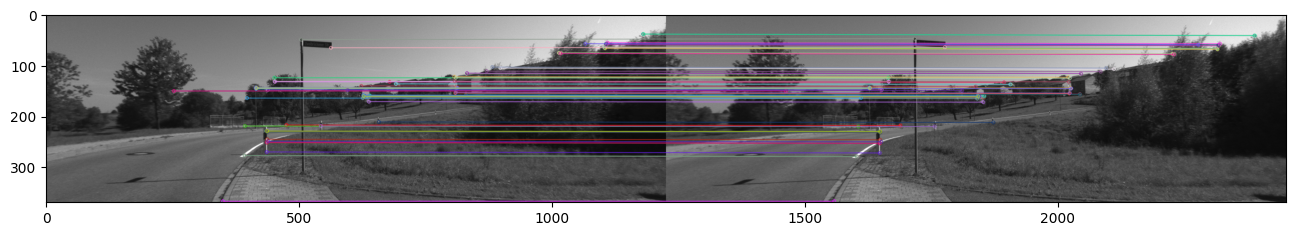

In [14]:
image_left = handler.first_image_left
print(image_left.shape)
image_right = handler.first_image_right
image_plus1 = handler.second_image_left
depth = stereo_2_depth(image_left, 
                       image_right, 
                       handler.P0, 
                       handler.P1,
                       matcher='bm',
                       verbose=True)
kp0, des0 = extract_features(image_left, 'harris')
kp1, des1 = extract_features(image_plus1, 'harris')
matches = match_features(des0, des1, matching='BF', detector='harris', sort=True)
print('Number of matches before filtering:', len(matches))
matches = filter_matches_distance(matches, 0.45)
print('Number of matches after filtering:', len(matches))
visualize_matches(image_left, kp0, image_plus1, kp1, matches)

In [15]:
# def estimate_motion(match, kp1, kp2, k, depth1=None, max_depth=3000):
#     """
#     Estimate camera motion from a pair of subsequent image frames

#     Arguments:
#     match -- list of matched features from the pair of images
#     kp1 -- list of the keypoints in the first image
#     kp2 -- list of the keypoints in the second image
#     k -- camera intrinsic calibration matrix 
    
#     Optional arguments:
#     depth1 -- Depth map of the first frame. Set to None to use Essential Matrix decomposition
#     max_depth -- Threshold of depth to ignore matched features. 3000 is default

#     Returns:
#     rmat -- estimated 3x3 rotation matrix
#     tvec -- estimated 3x1 translation vector
#     image1_points -- matched feature pixel coordinates in the first image. 
#                      image1_points[i] = [u, v] -> pixel coordinates of i-th match
#     image2_points -- matched feature pixel coordinates in the second image. 
#                      image2_points[i] = [u, v] -> pixel coordinates of i-th match
               
#     """
#     rmat = np.eye(3)
#     tvec = np.zeros((3, 1))
    
#     image1_points = np.float32([kp1[m.queryIdx].pt for m in match])
#     image2_points = np.float32([kp2[m.trainIdx].pt for m in match])

#     # print("image points")
#     # print(image1_points)
#     # print(k)
    
#     if depth1 is not None:
#         cx = k[0, 2]
#         cy = k[1, 2]
#         fx = k[0, 0]
#         fy = k[1, 1]
#         object_points = np.zeros((0, 3))
#         delete = []
        
#         listofx1=[]
#         listofy1=[]
#         listofz1=[]
        
#         # Extract depth information of query image at match points and build 3D positions
#         for i, (u, v) in enumerate(image1_points):
#             z1 = depth1[int(v), int(u)]
            

#             if z1 > max_depth:
#                 delete.append(i)
#                 continue
                
#             # Use arithmetic to extract x and y (faster than using inverse of k)
#             x1 = z1*(u-cx)/fx
#             y1 = z1*(v-cy)/fy
            
#             listofx1.append(x1)
#             listofy1.append(y1)
#             listofz1.append(z1)
            
#             p_c = np.linalg.inv(k) @ (x1 * np.array([u, v, 1]))
            
#             # print("XYZ sep")
#             # print(x1)
#             # print(y1)
#             # print(z1)
#             np.vstack([object_points, np.array([x1, y1, z1])])

#             # Equivalent math with dot product w/ inverse of k matrix, but SLOWER (see Appendix A)
#             # object_points = np.vstack([object_points, np.linalg.inv(k).dot(z*np.array([u, v, 1]))])

#         listofx2=[]
#         listofy2=[]
#         listofz2=[]
#         # Extract depth information of query image at match points and build 3D positions
#         for i, (u1, v1) in enumerate(image2_points):
#             z2 = depth1[int(v1), int(u1)]
            

#             # if z2 > max_depth:
#             #     delete.append(i)
#             #     continue
                
#             # Use arithmetic to extract x and y (faster than using inverse of k)
#             x2 = z2*(u1-cx)/fx
#             y2 = z2*(v1-cy)/fy
            
#             listofx2.append(x2)
#             listofy2.append(y2)
#             listofz2.append(z2)
#             # Equivalent math with dot product w/ inverse of k matrix, but SLOWER (see Appendix A)
#             # object_points = np.vstack([object_points, np.linalg.inv(k).dot(z*np.array([u, v, 1]))])

#         image1_points = np.delete(image1_points, delete, 0)

#         image2_points = np.delete(image2_points, delete, 0)
#         # print(object_points)
        
        
#         # Use PnP algorithm with RANSAC for robustness to outliers
        
#         _,rvec, tvec, inliers = cv2.solvePnPRansac(object_points, image2_points, cameraMatrix=k, distCoeffs=None)

#         rmat = cv2.Rodrigues(rvec)[0]
        
#         # listofxyz1 = np.array([listofx1,listofy1,listofz1])
#         listofxyz1 = np.vstack((listofx1,listofy1,listofz1))
#         listofxyz1 = listofxyz1.tolist()

#         # listofxyz2 = np.array([listofx2,listofy2,listofz2])
#         listofxyz2 = np.vstack((listofx2,listofy2,listofz2))
#         listofxyz2 = listofxyz2.tolist()


    
#     # listofxyz2 = np.array([x2,y2,z2])
#     else:
#         # With no depth provided, use essential matrix decomposition instead. This is not really
#         # very useful, since you will get a 3D motion tracking but the scale will be ambiguous
#         image1_points_hom = np.hstack([image1_points, np.ones(len(image1_points)).reshape(-1,1)])
#         image2_points_hom = np.hstack([image2_points, np.ones(len(image2_points)).reshape(-1,1)])
#         E = cv2.findEssentialMat(image1_points, image2_points, k)[0]
#         _, rmat, tvec, mask = cv2.recoverPose(E, image1_points, image2_points, k)

    
#     return rmat, tvec, image1_points, image2_points, listofxyz1, listofxyz2

In [16]:
def estimate_motion(match, kp1, kp2, k, depth1=None, max_depth=3000):
    """
    Estimate camera motion from a pair of subsequent image frames

    Arguments:
    match -- list of matched features from the pair of images
    kp1 -- list of the keypoints in the first image
    kp2 -- list of the keypoints in the second image
    k -- camera intrinsic calibration matrix 
    
    Optional arguments:
    depth1 -- Depth map of the first frame. Set to None to use Essential Matrix decomposition
    max_depth -- Threshold of depth to ignore matched features. 3000 is default

    Returns:
    rmat -- estimated 3x3 rotation matrix
    tvec -- estimated 3x1 translation vector
    image1_points -- matched feature pixel coordinates in the first image. 
                     image1_points[i] = [u, v] -> pixel coordinates of i-th match
    image2_points -- matched feature pixel coordinates in the second image. 
                     image2_points[i] = [u, v] -> pixel coordinates of i-th match
               
    """
    rmat = np.eye(3)
    tvec = np.zeros((3, 1))
    
    image1_points = np.float32([kp1[m.queryIdx].pt for m in match])
    image2_points = np.float32([kp2[m.trainIdx].pt for m in match])

    if depth1 is not None:
        cx = k[0, 2]
        cy = k[1, 2]
        fx = k[0, 0]
        fy = k[1, 1]
        object_points = np.zeros((0, 3))
        delete = []
        
        listofx1=[]
        listofy1=[]
        listofz1=[]
        
        
            
            
        # Extract depth information of query image at match points and build 3D positions
        for i, (u, v) in enumerate(image1_points):
            z1 = depth1[int(v), int(u)]
            # If the depth at the position of our matched feature is above 3000, then we
            # ignore this feature because we don't actually know the depth and it will throw
            # our calculations off. We add its index to a list of coordinates to delete from our
            # keypoint lists, and continue the loop. After the loop, we remove these indices
            if z1 > max_depth:
                delete.append(i)
                continue
                
            # Use arithmetic to extract x and y (faster than using inverse of k)
            x1 = z1*(u-cx)/fx
            y1 = z1*(v-cy)/fy
            listofx1.append(x1)
            listofy1.append(y1)
            listofz1.append(z1)
            object_points = np.vstack([object_points, np.array([x1, y1, z1])])
            # Equivalent math with dot product w/ inverse of k matrix, but SLOWER (see Appendix A)
            #object_points = np.vstack([object_points, np.linalg.inv(k).dot(z*np.array([u, v, 1]))])
        listofx2=[]
        listofy2=[]
        listofz2=[]
        # Extract depth information of query image at match points and build 3D positions
        for i, (u1, v1) in enumerate(image2_points):
            z2 = depth1[int(v1), int(u1)]
            

            # if z2 > max_depth:
            #     delete.append(i)
            #     continue
                
            # Use arithmetic to extract x and y (faster than using inverse of k)
            x2 = z2*(u1-cx)/fx
            y2 = z2*(v1-cy)/fy
            
            listofx2.append(x2)
            listofy2.append(y2)
            listofz2.append(z2)
            
        
        image1_points = np.delete(image1_points, delete, 0)
        image2_points = np.delete(image2_points, delete, 0)
        
        # Use PnP algorithm with RANSAC for robustness to outliers
        _, rvec, tvec, inliers = cv2.solvePnPRansac(object_points, image2_points, k, None)
        #print('Number of inliers: {}/{} matched features'.format(len(inliers), len(match)))
        
        # Above function returns axis angle rotation representation rvec, use Rodrigues formula
        # to convert this to our desired format of a 3x3 rotation matrix
        rmat = cv2.Rodrigues(rvec)[0]
        listofxyz1 = np.array([listofx1,listofy1,listofz1])
        listofxyz1 = np.vstack((listofx1,listofy1,listofz1))
        listofxyz1 = listofxyz1.tolist()

        # listofxyz2 = np.array([listofx2,listofy2,listofz2])
        listofxyz2 = np.vstack((listofx2,listofy2,listofz2))
        listofxyz2 = listofxyz2.tolist()


    
    else:
        # With no depth provided, use essential matrix decomposition instead. This is not really
        # very useful, since you will get a 3D motion tracking but the scale will be ambiguous
        image1_points_hom = np.hstack([image1_points, np.ones(len(image1_points)).reshape(-1,1)])
        image2_points_hom = np.hstack([image2_points, np.ones(len(image2_points)).reshape(-1,1)])
        E = cv2.findEssentialMat(image1_points, image2_points, k)[0]
        _, rmat, tvec, mask = cv2.recoverPose(E, image1_points, image2_points, k)
    
    return rmat, tvec, image1_points, image2_points, listofxyz1, listofxyz2

In [17]:
def visual_odometry(handler, detector='sift', matching='BF', filter_match_distance=None, 
                    stereo_matcher='bm', mask=None, depth_type='stereo', subset=None,
                    plot=False):
    '''
    Function to perform visual odometry on a sequence from the KITTI visual odometry dataset.
    Takes as input a Data_Handler object and optional parameters.
    
    Arguments:
    handler -- Data_Handler object instance
    
    Optional Arguments:
    detector -- (str) can be 'sift' or 'orb'. Default is 'sift'.
    matching -- (str) can be 'BF' for Brute Force or 'FLANN'. Default is 'BF'.
    filter_match_distance -- (float) value for ratio test on matched features. Default is None.
    stereo_matcher -- (str) can be 'bm' (faster) or 'sgbm' (more accurate). Default is 'bm'.
    mask -- (array) mask to reduce feature search area to where depth information available.
    depth_type -- (str) can be 'stereo' or set to None to use Essential matrix decomposition.
                        Note that scale will be incorrect with no depth used.
    subset -- (int) number of frames to compute. Defaults to None to compute all frames.
    plot -- (bool) whether to plot the estimated vs ground truth trajectory. Only works if
                   matplotlib is set to tk mode. Default is False.
    
    Returns:
    trajectory -- Array of shape Nx3x4 of estimated poses of vehicle for each computed frame.
    
    '''
    
    # Report methods being used to user
    # print('Generating disparities with Stereo{}'.format(str.upper(stereo_matcher)))
    # print('Detecting features with {} and matching with {}'.format(str.upper(detector), 
    #                                                                matching))
    if filter_match_distance is not None:
        print('Filtering feature matches at threshold of {}*distance'.format(filter_match_distance))
    
    if subset is not None:
        #subset = subset + 1
        num_frames = subset
    else:
        # Set num_frames to one less than the number of frames so we have sequential images
        # in the last frame run.
        num_frames = handler.num_frames
        
    if plot:
        fig = plt.figure(figsize=(14, 14))
        ax = fig.add_subplot(111, projection='3d')
        ax.view_init(elev=-20, azim=270)
        xs = handler.gt[:, 0, 3]
        ys = handler.gt[:, 1, 3]
        zs = handler.gt[:, 2, 3]
        ax.set_box_aspect((np.ptp(xs), np.ptp(ys), np.ptp(zs)))
        ax.plot(xs, ys, zs, c='k')
    # Establish homogeneous transformation matrix. First pose is identity    
    T_tot = np.eye(4)
    trajectory = np.zeros((num_frames, 3, 4))
    trajectory[0] = T_tot[:3, :]
    imheight = handler.imheight
    imwidth = handler.imwidth




    # Decompose left camera projection matrix to get intrinsic k matrix
    k_left, r_left, t_left = decompose_projection_matrix(handler.P0)


    if handler.low_memory:
        handler.reset_frames()

        image_plus1 = next(handler.images_left)
        depth_plus1 =next(handler.depths_left)
        


    combined_dict ={"Frame_t":[],"Frame_t+1":[]}

    # Iterate through all frames of the sequence
    for i in range(num_frames - 1):
        # Stop if we've reached the second to last frame, since we need two sequential frames
        #if i == num_frames - 1:
        #    break
        # Start timer for frame
        start = datetime.datetime.now()
        # Get our stereo images for depth estimation
        
        
        if handler.low_memory:
            image_left = image_plus1
            image_right = next(handler.images_right)
            # Get next frame in the left camera for visual odometry
            image_plus1 = next(handler.images_left)
        else:
            image_left = handler.images_left[i]
            image_right = handler.images_right[i]
            # Get next frame in the left camera for visual odometry
            image_plus1 = handler.images_left[i+1]
        

        # Estimate depth if using stereo depth estimation (recommended)
        if depth_type == 'stereo':
            depth = stereo_2_depth(image_left, 
                                   image_right, 
                                   P0=handler.P0, 
                                   P1=handler.P1,
                                   matcher=stereo_matcher)
            # depth = depth_plus1/80
            # depth_plus1 = next(handler.depths_left)

            # depth = None
        # Otherwise use Essential Matrix decomposition (ambiguous scale)
        else:
            depth = None
            
        

        # Get keypoints and descriptors for left camera image of two sequential frames
        kp0, des0 = extract_features(image_left, detector, mask)
        kp1, des1 = extract_features(image_plus1, detector, mask)
        
        # Get matches between features detected in the two images
        matches_unfilt = match_features(des0, 
                                        des1, 
                                        matching=matching, 
                                        detector=detector, 
                                        sort=True)
        
        # Filter matches if a distance threshold is provided by user
        if filter_match_distance is not None:
            matches = filter_matches_distance(matches_unfilt, filter_match_distance)
        else:
            matches = matches_unfilt
            
        # Estimate motion between sequential images of the left camera
        
        # print("THIS is kp0:  ")
        # for keypoint0 in kp0:
        #     print(keypoint0.pt)
        #     print(keypoint0.angle)
        # print("This is kp1:  ")
        # for keypoint1 in kp1:
        #     print(keypoint1.pt)
        #     print(keypoint1.angle)
        # print("Matches detected:  ")
        
        list_kp0 = []
        list_kp1 = []

        # For each match...
        for mat in matches:

            # Get the matching keypoints for each of the images
            img1_idx = mat.queryIdx
            img2_idx = mat.trainIdx

            # x - columns
            # y - rows
            # Get the coordinates
            (x1, y1) = kp0[img1_idx].pt
            (x2, y2) = kp1[img2_idx].pt

            # Append to each list
            list_kp0.append((x1, y1))
            list_kp1.append((x2, y2))
        # print("This is KP0:   ")
        # print(list_kp0)
        # print("This is KP1:   ") 
        # print(list_kp1)
        pd.set_option('display.max_columns', None)
        pd.set_option('display.expand_frame_repr', False)
        pd.set_option('max_colwidth', None)
        d = {'kp0': list_kp0, 'kp1': list_kp1}
        df = pd.DataFrame(data=d)
        # print(df)

                    
            
        rmat, tvec, img1_points, img2_points,listxyz1, listxyz2 = estimate_motion(matches, kp0, kp1, k=k_left, depth1=depth)

        combined_dict["Frame_t"].append(listxyz1)
        combined_dict["Frame_t+1"].append(listxyz2)
        
        

        # Create blank homogeneous transformation matrix
        Tmat = np.eye(4)
        # Place resulting rotation matrix  and translation vector in their proper locations
        # in homogeneous T matrix
        Tmat[:3, :3] = rmat
        Tmat[:3, 3] = tvec.T

        T_tot = T_tot.dot(np.linalg.inv(Tmat))
            
        # Place pose estimate in i+1 to correspond to the second image, which we estimated for
        trajectory[i+1, :, :] = T_tot[:3, :]
        # End the timer for the frame and report frame rate to user
        end = datetime.datetime.now()
        print('Time to compute frame {}:'.format(i+1), end-start)
        if plot:
            xs = trajectory[:i+2, 0, 3]
            ys = trajectory[:i+2, 1, 3]
            zs = trajectory[:i+2, 2, 3]
            plt.plot(xs, ys, zs, c='chartreuse')
            plt.pause(1e-32)
            # print("THIS is xs in VO")
            # print(xs)
            # print(ys)
            # print(zs)
    if plot:        
        plt.close()
    


    # print(combined_dict)
    
     
    return trajectory, combined_dict


In [18]:
%matplotlib inline

In [19]:

trajectory_nolidar_bm_sift, combined_dict_sift = visual_odometry(handler,
                                        filter_match_distance=0.45,
                                        detector='sift',
                                        # matching='FLANN',
                                        stereo_matcher='bm',
                                        mask=None,     
                                        subset=None,
                                        plot=False)


Filtering feature matches at threshold of 0.45*distance
Time to compute frame 1: 0:00:00.261993
Time to compute frame 2: 0:00:00.262041
Time to compute frame 3: 0:00:00.259509
Time to compute frame 4: 0:00:00.275846
Time to compute frame 5: 0:00:00.258153
Time to compute frame 6: 0:00:00.275176
Time to compute frame 7: 0:00:00.274677
Time to compute frame 8: 0:00:00.259113
Time to compute frame 9: 0:00:00.274671
Time to compute frame 10: 0:00:00.292334
Time to compute frame 11: 0:00:00.273537
Time to compute frame 12: 0:00:00.261193
Time to compute frame 13: 0:00:00.275396
Time to compute frame 14: 0:00:00.273547
Time to compute frame 15: 0:00:00.270950
Time to compute frame 16: 0:00:00.296753
Time to compute frame 17: 0:00:00.303095
Time to compute frame 18: 0:00:00.318904
Time to compute frame 19: 0:00:00.320240


In [20]:


# import sys 
# stdoutOrigin=sys.stdout 
# sys.stdout = open("log.csv", "w")
# # open file for writing

trajectory_nolidar_bm_harris, combined_dict_harris = visual_odometry(handler,
                                        filter_match_distance=0.45,
                                        detector='harris',
                                        # matching='FLANN',
                                        stereo_matcher='bm',
                                        mask=None,     
                                        subset=None,
                                        plot=False)

# print(combined_dict["Frame_t"][0])


# f = open("dict.txt","w")

# # write file
# f.write( str(combined_dict) )

# # close file
# f.close()

# import json


# json = json.dumps(combined_dict)

# # open file for writing, "w" 
# f = open("dict.json","w")

# # write json object to file
# f.write(json)

# # close file
# f.close()
# print(trajectory_nolidar_bm[1,1])



Filtering feature matches at threshold of 0.45*distance
Time to compute frame 1: 0:00:11.504374
Time to compute frame 2: 0:00:11.580020
Time to compute frame 3: 0:00:12.188442
Time to compute frame 4: 0:00:11.488733
Time to compute frame 5: 0:00:11.838421
Time to compute frame 6: 0:00:11.189060
Time to compute frame 7: 0:00:10.857520
Time to compute frame 8: 0:00:10.890079
Time to compute frame 9: 0:00:10.979559
Time to compute frame 10: 0:00:12.750075
Time to compute frame 11: 0:00:10.775181
Time to compute frame 12: 0:00:10.849079
Time to compute frame 13: 0:00:10.854656
Time to compute frame 14: 0:00:10.850013
Time to compute frame 15: 0:00:10.999396
Time to compute frame 16: 0:00:12.181440
Time to compute frame 17: 0:00:10.754491
Time to compute frame 18: 0:00:11.206779
Time to compute frame 19: 0:00:11.211777


In [21]:
trajectory_nolidar_bm_harris_skew, combined_dict_harris_skew = visual_odometry(handler,
                                        filter_match_distance=0.45,
                                        detector='harris-skew',
                                        # matching='FLANN',
                                        stereo_matcher='bm',
                                        mask=None,     
                                        subset=None,
                                        plot=False)

Filtering feature matches at threshold of 0.45*distance
Time to compute frame 1: 0:00:11.600560
Time to compute frame 2: 0:00:11.199363
Time to compute frame 3: 0:00:12.384048
Time to compute frame 4: 0:00:11.161651
Time to compute frame 5: 0:00:11.257857
Time to compute frame 6: 0:00:11.602484
Time to compute frame 7: 0:00:11.805217
Time to compute frame 8: 0:00:11.566972
Time to compute frame 9: 0:00:12.256207
Time to compute frame 10: 0:00:11.729479
Time to compute frame 11: 0:00:14.797274
Time to compute frame 12: 0:00:13.728632
Time to compute frame 13: 0:00:14.532424
Time to compute frame 14: 0:00:13.978577
Time to compute frame 15: 0:00:13.376986
Time to compute frame 16: 0:00:13.796147
Time to compute frame 17: 0:00:13.112092
Time to compute frame 18: 0:00:12.228565
Time to compute frame 19: 0:00:12.673818


In [22]:
# import sys 
# stdoutOrigin=sys.stdout 
# sys.stdout = open("testing.csv", "w")
# print(combined_dict["Frame_t"][5][0]) #Index 0 of frame1, x value
# print(combined_dict["Frame_t"][0][1]) #Index 0 of frame1, y value

# print(combined_dict["Frame_t+1"][0][2]) #Index 0 of frame2, z value

# print(combined_dict)

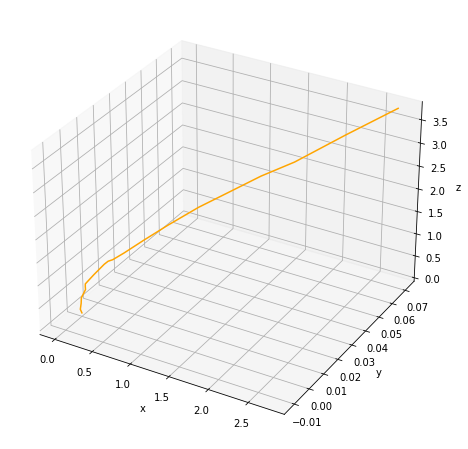

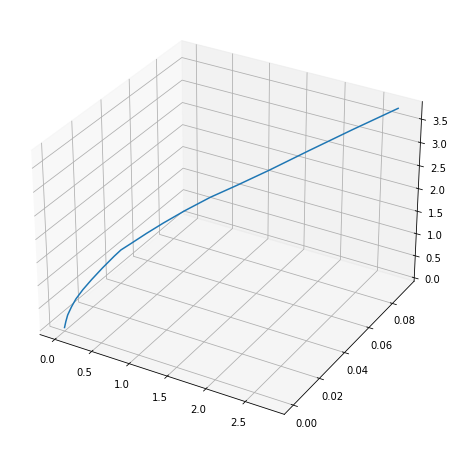

In [23]:
fig = plt.figure(figsize=(12,8))
fig2 = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')
ay = fig2.add_subplot(111,projection='3d')

ax.plot(trajectory_nolidar_bm_sift[:, :, 3][:, 0], 
        trajectory_nolidar_bm_sift[:, :, 3][:, 1], 
        trajectory_nolidar_bm_sift[:, :, 3][:, 2], label='estimated', color='orange')

ay.plot(handler.gt[:, :, 3][:, 0], 
        handler.gt[:, :, 3][:, 1], 
        handler.gt[:, :, 3][:, 2], label='ground truth')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

plt.show()

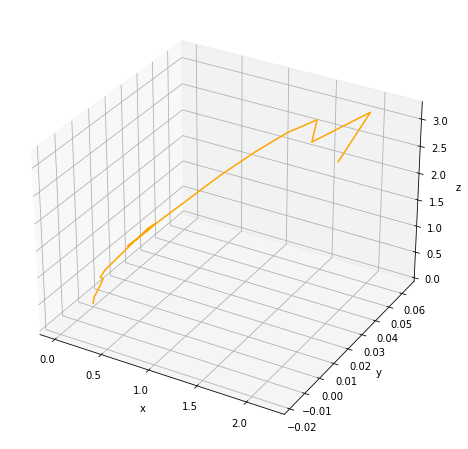

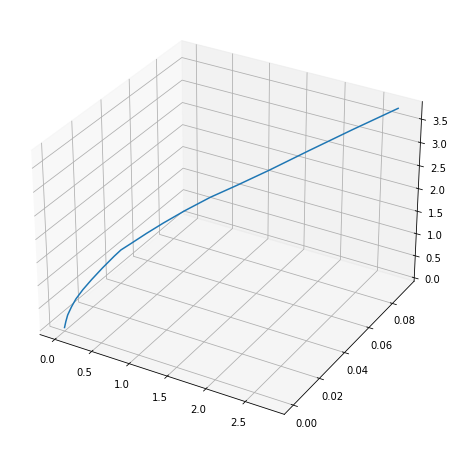

In [24]:
fig = plt.figure(figsize=(12,8))
fig2 = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')
ay = fig2.add_subplot(111,projection='3d')

ax.plot(trajectory_nolidar_bm_harris[:, :, 3][:, 0], 
        trajectory_nolidar_bm_harris[:, :, 3][:, 1], 
        trajectory_nolidar_bm_harris[:, :, 3][:, 2], label='estimated', color='orange')

ay.plot(handler.gt[:, :, 3][:, 0], 
        handler.gt[:, :, 3][:, 1], 
        handler.gt[:, :, 3][:, 2], label='ground truth')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

plt.show()

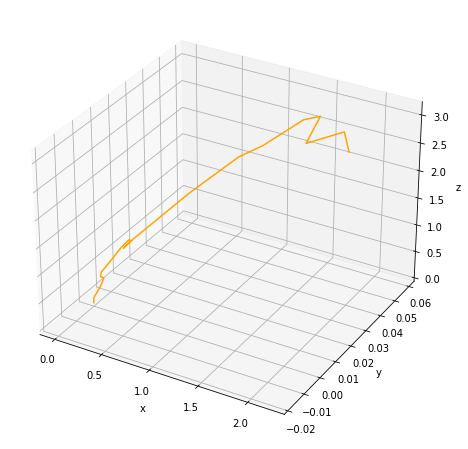

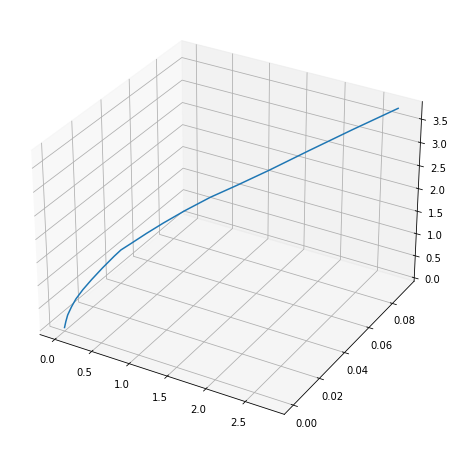

In [25]:
fig = plt.figure(figsize=(12,8))
fig2 = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')
ay = fig2.add_subplot(111,projection='3d')

ax.plot(trajectory_nolidar_bm_harris_skew[:, :, 3][:, 0], 
        trajectory_nolidar_bm_harris_skew[:, :, 3][:, 1], 
        trajectory_nolidar_bm_harris_skew[:, :, 3][:, 2], label='estimated', color='orange')

ay.plot(handler.gt[:, :, 3][:, 0], 
        handler.gt[:, :, 3][:, 1], 
        handler.gt[:, :, 3][:, 2], label='ground truth')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

plt.show()

In [26]:
import json



# open file for writing, "w" 
f = open("dd.json","w")
# write json object to file
f.write(str(handler.gt))

# close file
f.close()


In [27]:
def calculate_error(ground_truth, estimated, error_type='mse'):
    '''
    Takes arrays of ground truth and estimated poses of shape Nx3x4, and computes error using
    Euclidean distance between true and estimated 3D coordinate at each position.
    
    Arguments:
    ground_truth -- Nx3x4 array of ground truth poses
    estimated -- Nx3x4 array of estimated poses
    
    Optional Arguments:
    error_type -- (str) can be 'mae', 'mse', 'rmse', or 'all' to return dictionary of all 3
    
    Returns:
    error -- either a float or dictionary of error types and float values
    
    '''
    # Find the number of frames in the estimated trajectory to compare with
    nframes_est = estimated.shape[0]-1
    
    def get_mse(ground_truth, estimated):
        se = np.sqrt((ground_truth[nframes_est, 0, 3] - estimated[:, 0, 3])**2 
                    + (ground_truth[nframes_est, 1, 3] - estimated[:, 1, 3])**2 
                    + (ground_truth[nframes_est, 2, 3] - estimated[:, 2, 3])**2)**2
        mse = se.mean()
        return mse
    
    def get_mae(ground_truth, estimated):
        ae = np.sqrt((ground_truth[nframes_est, 0, 3] - estimated[:, 0, 3])**2 
                    + (ground_truth[nframes_est, 1, 3] - estimated[:, 1, 3])**2 
                    + (ground_truth[nframes_est, 2, 3] - estimated[:, 2, 3])**2)
        mae = ae.mean()
        return mae
    
    if error_type == 'mae':
        return get_mae(ground_truth, estimated)
    elif error_type == 'mse':
        return get_mse(ground_truth, estimated)
    elif error_type == 'rmse':
        return np.sqrt(get_mse(ground_truth, estimated))
    elif error_type == 'all':
        mae = get_mae(ground_truth, estimated)
        mse = get_mse(ground_truth, estimated)
        rmse = np.sqrt(mse)
        return {'mae': mae,
                'rmse': rmse,
                'mse': mse}

In [28]:
calculate_error(handler.gt, trajectory_nolidar_bm_sift, 'all')

{'mae': 2.7842448522105974,
 'rmse': 3.1313389627085826,
 'mse': 9.805283699376862}

In [29]:
calculate_error(handler.gt, trajectory_nolidar_bm_harris, 'all')

{'mae': 3.0222301260874653,
 'rmse': 3.2377263200733766,
 'mse': 10.48287172369589}

In [30]:
calculate_error(handler.gt, trajectory_nolidar_bm_harris_skew, 'all')

{'mae': 3.014293600689606,
 'rmse': 3.225744618700557,
 'mse': 10.405428345075604}